# Semestrální práce - PLI

In [51]:
# Import knihovny Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Import knihovny transformers pro práci s modely z HuggingFace
from transformers import ElectraTokenizer, AutoModel

# Import knihovny re pro regulární výrazy
import re

# Import knihovny pro výpočet F1 skóre
from sklearn.metrics import f1_score

# Import knihovny pro usnadnění trénování a zobrazení jeho průběhu
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [52]:
# Načtení trénovacích dat

with open("train_data.utf8", "r", encoding='utf-8') as f:
    text_data = f. read()

# Znak pro nový řádek se nahradí za mezeru

text_data = text_data.replace("\n", " ")

# Odstranění všech nestandartních znaků (zachová pouze a-z, A-Z, znaky české abecedy, mezery, číslice, symbol tečka, čárka, otazník a vykřičník).

text_data_clean = re.sub(r'[^a-zA-Z0-9.,!?áčďéěíňóřšťúůýžÁČĎÉĚÍŇÓŘŠŤÚŮÝŽ ]', '', text_data)

# Odstranění duplicitních mezer

text_data_clean = re.sub(r'\s+', ' ', text_data_clean).strip()

# Převedení všech znaků na lower-case

# text_data_clean = text_data_clean.lower()

### CapitalizationModel
`CapitalizationModel` využívá architekturu Electra, která se načítá přes `AutoModel.from_pretrained`, rozšířenou o lineární vrstvu `nn.Linear` s 256 vstupními a 2 výstupními prvky (2 třídy), která se provádí pro každý vstupní token. Funkce `forward` popisuje průchod dat modelem: nejprve Electra modelem a následně lineární vrstvou pro výstup.

In [115]:
class CapitalizationModel(nn.Module):
    def __init__(self, name):
        super(CapitalizationModel, self).__init__()
        self.electra_model = AutoModel.from_pretrained(name)
        
        self.linear_layer = nn.Linear(in_features=256, out_features=2)

    def forward(self, x, attn_masks):
        x = self.electra_model(x, attention_mask=attn_masks)[0]

        output = self.linear_layer(x)

        return output

### Inicializace a Nastavení Modelu

Inicializujeme `CapitalizationModel` s předtrénovanou ELECTRA architekturou pro češtinu (`"Seznam/small-e-czech"`). Následně model přesuneme na GPU pro efektivnější výpočty, pokud je GPU k dispozici. V opačném případě použijeme CPU. Nakonec model přepneme do trénovacího režimu voláním `capitalization_model.train()`, aby byl připraven na učení.

In [116]:
# Inicializace modelu

capitalization_model = CapitalizationModel("Seznam/small-e-czech")

# Přesun modelu na GPU, pokud je k dispozici

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
capitalization_model.to(device)

capitalization_model.train()



CapitalizationModel(
  (electra_model): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in

### Rozdělení Dat na Trénovací a Validační Set

Data jsou rozdělena na trénovací a validační set s použitím validačního splitu 5%. Tento proces začíná rozdělením čistěného textu na jednotlivá slova a následným výpočtem celkového počtu slov.

Index pro rozdělení dat se vypočítá jako 95% celkového počtu slov, což určuje hranici mezi trénovacími a validačními daty. Trénovací data zahrnují slova od začátku do tohoto indexu, zatímco validační data zahrnují zbytek.

In [117]:
# Rozdělní dat na validační a trénovací

VALIDATION_SPLIT = 0.05 # 5% z celkových dat bude validačních

words = text_data_clean.split(" ")
words_count = len(words)

split_index = round(words_count * (1 - VALIDATION_SPLIT))

train_data = words[0:split_index]
validation_data = words[split_index:words_count]

### Inicializace Tokenizéru a Definice Funkce pro Tokenizaci

Inicializujeme `ElectraTokenizer` s modelem specifickým pro češtinu ("Seznam/small-e-czech") pro převod slov na tokeny. Definovaná funkce `tokenization` přijímá seznam slov a s použitím tokenizéru vytváří seznam tokenů a přiřazuje jim labely (každý slovo vždy musí mít stejný počet tokenů a labelů) na základě kapitalizace: 0 pro malá písmena a 1 pro velká písmena na začátku slova. Funkce podporuje zpracování velkého množství dat díky postupnému přidávání tokenů a labelů do seznamů a vrací dva seznamy: tokeny a jejich štítky.

Podrobný popis tokenizeru viz. [ELECTRA](https://huggingface.co/docs/transformers/v4.14.1/model_doc/electra#transformers.ElectraTokenizer)

Příklad slova s velkým počátečním písmenem: "Libverda"
- Tokens: ['lib', '##ver', '##da'] -> IDs: [5915, 925, 372]
- Labels: [1, 0, 0]

Příklad slova s malými písmeny: "libverda"
- Tokens: ['lib', '##ver', '##da'] -> IDs: [5915, 925, 372]
- Labels: [0, 0, 0]

In [58]:
# Incializace tokenizéru

tokenizer = ElectraTokenizer.from_pretrained("Seznam/small-e-czech", special=False)

# Funkce pro tokenizaci
# Funkce přijímá list slov a vrací jeden list s tokeny a jeden list s labely (u prvního tokenu 0 pro lower-case, 1 pro upper-case)

# U tokenizeru je nutné vypnout přidávání speciálních tokenů

def tokenization(data, tokenizer) -> [list, list]:
    tokens = []
    labels = []

    for word in tqdm(data, desc="Tokenizace", mininterval=1.0):
        capital = False
        if word[0].isupper():
            capital = True
        # tady nekde prevod tokenu na lowercase
        tokenized_word = tokenizer.tokenize(word.lower())
        tokenized_ids = tokenizer.convert_tokens_to_ids(tokenized_word)
        # Nebo takhle
        # tokenizer.encode(word, add_special_tokens=False)
        # pokud je prvni pismeno ve Word capital, tak bude prvni label 1
        for ids in tokenized_ids:
            tokens.append(ids)
            if capital:
                labels.append(1)
                capital = False
            else:
                labels.append(0)
    return tokens, labels

validation_tokens, validation_labels = tokenization(validation_data, tokenizer)
train_tokens, train_labels = tokenization(train_data, tokenizer)

# KONTROLA: len(validation_tokens) == len(validation_labels) == 1033374
print(len(validation_tokens))
print(len(validation_labels))

Tokenizace: 100%|██████████| 14189144/14189144 [11:37<00:00, 20337.05it/s]

1033374
1033374


### Generátor Batchů

Funkce `batch_generator` slouží k vytváření batchů z tokenů a labelů pro efektivnější trénování modelu. Batche jsou tvořeny tak, že se rozdělí tokeny a labely na sekvence s pevnou délkou a následně se seskupí do menších skupin (batche) určené velikostí `batch_size`. Každý batch obsahuje také masku, která umožňuje modelu rozlišit relevantní tokeny od paddingu. V tomto případě, kdy mají batche konstantní délku, mají všechny tokeny masku nastavenou na 1.

Příklad použití:
`train_generator = batch_generator(train_tokens, train_labels, batch_size=8, length=128)`
Toto vytvoří generátor pro trénovací data s velikostí batche 8 a délkou sekvence 128 tokenů.

In [118]:
# Generátor batchů

# token_tensor.shape == mask_tensor.shape == label_tensor.shape == [8,128]

BATCH_SIZE = 8
SEQ_LEN = 128

def batch_generator(tokens, labels, batch_size = 8, length = 128) -> [torch.Tensor, torch.Tensor, torch.Tensor]:

    token_sequences = torch.reshape(torch.tensor(tokens[0:len(tokens)-(len(tokens)%(length*batch_size))]), (-1, batch_size, length))
    label_sequences = torch.reshape(torch.tensor(labels[0:len(labels)-(len(tokens)%(length*batch_size))]), (-1, batch_size, length))
    batch_count = int(len(tokens)/(length*batch_size))  # Nezapočítavejte a nepoužívejte poslední sekvenci, která neodpovídá požadované délce
    
    # KONTROLA: bacht_count == 19258

    while(True):
        for i in range(batch_count):
            
            token_tensor, label_tensor = token_sequences[i, :, :], label_sequences[i, :, :]
            mask_tensor = torch.ones_like(token_tensor)

            yield token_tensor, mask_tensor, label_tensor
    



train_generator = batch_generator(train_tokens, train_labels, BATCH_SIZE, SEQ_LEN)

test_batch = next(train_generator)

## KONTROLA: test_batch[0][1][2] == tensor(1046, dtype=torch.int32)

print(test_batch[0][1][2])

tensor(1046)


### Nastavení Trénovacích Parametrů

Pro trénování modelu používáme křížovou entropii (`nn.CrossEntropyLoss`) jako ztrátovou funkci, která je vhodná pro klasifikační úlohy. Jako optimalizační algoritmus zvolíme Adam (`optim.Adam`), který je populární díky své efektivitě a adaptivním vlastnostem. Learning rate je nastaven na 1e-4.

In [119]:
# Nastavení trénovacích parametrů

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(capitalization_model.parameters(), lr=1e-4)


### Testovací Dopředný Průchod Modelem

Pro testování funkčnosti modelu provedeme dopředný průchod s využitím jednoho batche z trénovacích dat. Nejprve vynulujeme gradienty v optimalizátoru, aby se zabránilo jejich nechtěné akumulaci. Poté načteme jeden batch dat pomocí `batch_generator` a provedeme dopředný průchod modelem s těmito daty. Výstup modelu je permutován pro splnění očekávaných rozměrů ztrátové funkce, na kterou aplikujeme vypočítanou ztrátu. Nakonec provedeme krok optimalizace.

F1 metrika je harmonický průměr přesnosti (precision) a úplnosti (recall), který se často používá jako metrika pro hodnocení klasifikačních modelů, zejména v případech, kde je nerovnováha tříd. F1 skóre dosahuje své nejlepší hodnoty u 1 (perfektní přesnost a úplnost) a nejhorší u 0.

In [61]:
# Iterace trénování modelu

optimizer.zero_grad() # Vynulování gradientů v optimalizátoru, aby se předešlo akumulaci při více iteracích

train_generator = batch_generator(train_tokens, train_labels, 8, 128)

inputs, masks, labels = next(train_generator)

output = capitalization_model.forward(inputs.cuda(), masks.cuda()) # Dopředný průchod modelem
output = output.permute(0,2,1) # Permutace výstupu modelu pro splnění očekávaných rozměrů pro loss kritérium

loss = criterion(output, labels.cuda()) # Výpočet ztráty mezi predikcemi a skutečnými labely

optimizer.step()

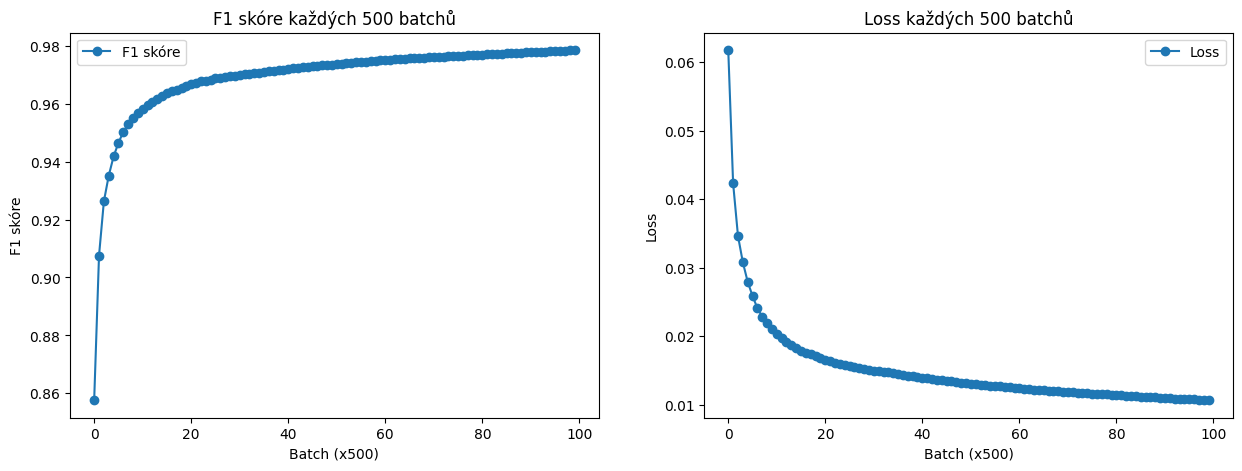

Training Loss: 0.0107 F1 skóre: 0.9785: 100%|██████████| 50000/50000 [1:35:51<00:00,  8.69it/s]


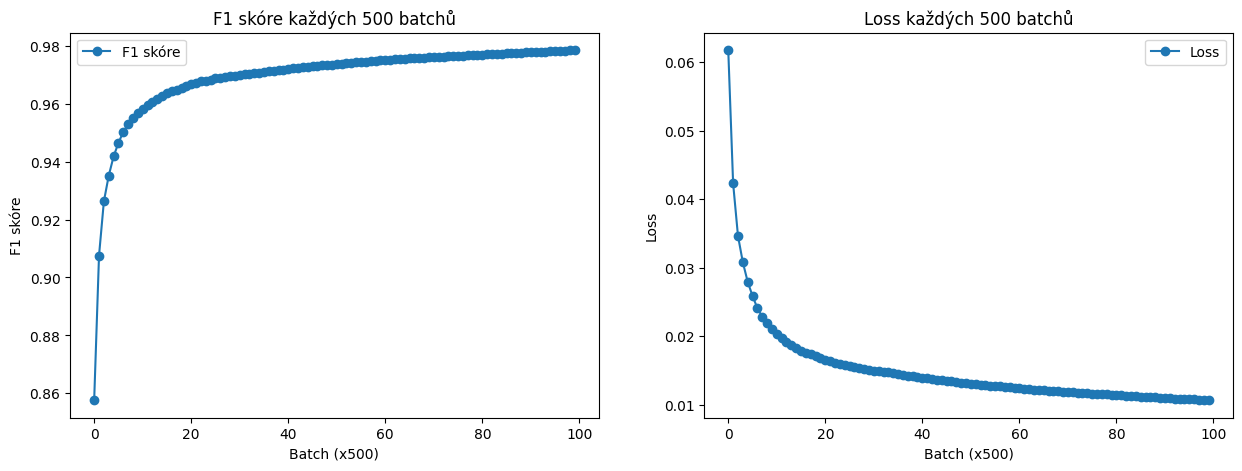

In [120]:
train_generator = batch_generator(train_tokens, train_labels, 8, 128)
#Incializace grafů a pomocných proměnných pro vykreslování
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.set_title('F1 skóre každých 500 batchů')
ax1.set_xlabel('Batch')
ax1.set_ylabel('F1 skóre')

ax2.set_title('Loss každých 500 batchů')
ax2.set_xlabel('Batch')
ax2.set_ylabel('Loss')

running_loss = 0
running_f1 = 0

loss_values = []
f1_scores = []

# Nastavení počtu interací pro trénování
t = trange(50000, desc="Training", mininterval=0.5)

# Trénovací smyčka
for i in t:

    # Zde doplnit (viz. iterace modelu)
    # Iterace trénování modelu

    optimizer.zero_grad() # Vynulování gradientů v optimalizátoru, aby se předešlo akumulaci při více iteracích
    
    inputs, masks, labels = next(train_generator)
    
    output = capitalization_model.forward(inputs.cuda(), masks.cuda()) # Dopředný průchod modelem
    output = output.permute(0,2,1) # Permutace výstupu modelu pro splnění očekávaných rozměrů pro loss kritérium
    
    loss = criterion(output, labels.cuda()) # Výpočet ztráty mezi predikcemi a skutečnými labely
    
    loss.backward()
    
    optimizer.step()
    
    running_loss += loss.item()
    f1 = f1_score(torch.argmax(output.clone().detach().cpu(),1).view(-1),labels.view(-1), average=None)
    running_f1 += f1[1]
    t.set_description(f"Training Loss: {(running_loss/(i+1)):.4f} F1 skóre: {(running_f1/(i+1)):.4f}", refresh=True)
    t.refresh()
    
    if (i+1) % 500 == 0:  # Každých 500 batchů
        f1_scores.append(running_f1/(i+1))
        loss_values.append(running_loss/(i+1))
        
        # Vymazání předchozích grafů
        ax1.clear()
        ax2.clear()

        # Nastavení titulků a os pro oba grafy
        ax1.set_title('F1 skóre každých 500 batchů')
        ax1.set_xlabel('Batch (x500)')
        ax1.set_ylabel('F1 skóre')
        ax2.set_title('Loss každých 500 batchů')
        ax2.set_xlabel('Batch (x500)')
        ax2.set_ylabel('Loss')

        # Aktualizace grafu pro F1 skóre
        ax1.plot(f1_scores, '-o', label='F1 skóre')
        ax1.legend()

        # Aktualizace grafu pro Loss
        ax2.plot(loss_values, '-o', label='Loss')
        ax2.legend()

        clear_output(wait=True)
        display(fig)  # Zobrazí aktuální figuru s oběma grafy




Očekávaný graf pro loss a F1 skóre (5000x batch).

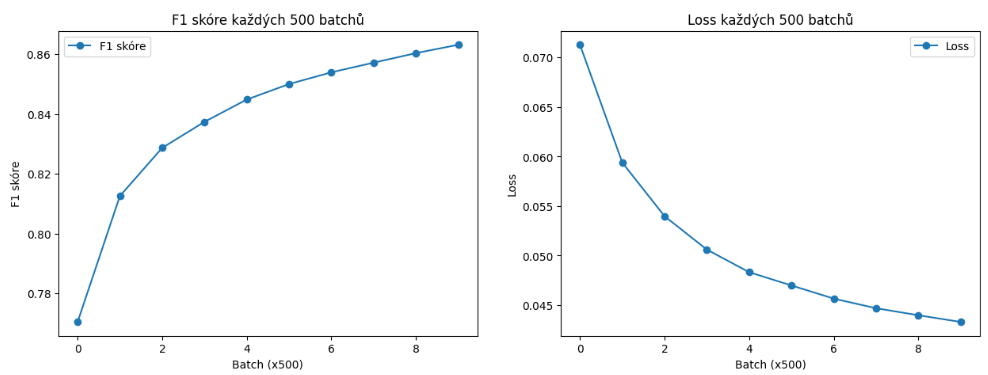

In [121]:
# Funkce, která na vstupu přijme text a na výstupu vygeneruje text, který bude včetně kapitalizace
def capitalize(text,model,tokenizer) -> str:
    model.eval()

    # Text na tokeny
    tokenized_text = tokenizer.tokenize(text)
    tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

    # Predikce kapitalizace
    input_tensor = torch.tensor(tokens).unsqueeze(0).to(device)
    attention_mask = torch.ones_like(input_tensor).to(device)
    with torch.no_grad():
        outputs = model(input_tensor, attention_mask)  # Assuming 'model' is a PyTorch model
        
    # Převod na ids
    predictions = torch.argmax(outputs, dim=2).squeeze(0)

    capitalized_text = []
    for token, pred in zip(tokenized_text, predictions):
        if pred == 1:
            capitalized_text.append(token.capitalize())
        else:
            capitalized_text.append(token)

    # Převod tokenů na text
    text_output = tokenizer.convert_tokens_to_string(capitalized_text)
    # Odstranit mezery před interpunkcí
    text_output = re.sub(r'\s([?.!",](?:\s|$))', r'\1', text_output)
    
    return text_output

In [122]:
input_text = "vítejte v liberci, kterým vás provede pan kovář. ahoj bedřichu, neboj se jít do lesa. já kdybych nebyl v maroku, tak bych letěl do prahy. nechtěl bys být václavem?"
print(capitalize(input_text, capitalization_model, tokenizer))

vítejte v Liberci, kterým vás provede pan Kovář. Ahoj Bedřichu, neboj se jít do lesa. Já kdybych nebyl v Maroku, tak bych letěl do Prahy. Nechtěl bys být Václavem?


## Bonus

Upravte funkci tokenization tak, aby místo zvětšování písmen dokázala generovat interpunkční znaménka (tečka, čárka a otazník).

Pro zjednodušení uvažujte pouze varianty, kdy se interpunkční znaménko nachází na konci slova (např. "konec?").

Celkem tak bude probíhat klasifikace do 4 tříd (Bez interpunkce, Otazník, Tečka, Čárka).

Následně vytvořte funkci punctuation, která do textu doplní interpunkci.